In [1]:
! pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.2 MB/s eta 0:00:00


In [2]:
! pip install keras-facenet

  Preparing metadata (setup.py) ... - done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10369 sha256=32b67550d2697f1558228a4a54be9b77347dd2d690ec3b7b71c7392fd6f10f7f
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


# Importing libraries

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import pickle
import contextlib
import sys
import io

# Making functions

In [4]:
detector = MTCNN()
embedder = FaceNet()

## Function to remove progress bars when processing data

In [5]:
@contextlib.contextmanager
def suppress_stdout():
    save_stdout = sys.stdout
    sys.stdout = io.StringIO()
    yield
    sys.stdout = save_stdout

## Getting the face from the image after detecting

In [6]:
def get_face(img,box):
    x,y,w,h = box
    p = (x+w,y+h)
    face = img[y:y+h,x:x+w]
    face = cv2.resize(face,(160,160))
    return face,x,y,p

# Encoding faces using FaceNet

In [7]:
def get_embedding(face):
    face = cv2.resize(face,(160,160))
    face = face.astype('float32')
    face = np.expand_dims(face,axis=0)
    with suppress_stdout():
        embedding = embedder.embeddings(face)
    return embedding[0]

## Taking an image and outputing the image after detecting using mtcnn,FaceNet and svm

In [8]:
def detect_recognize_faces(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(img)
    faces = []
    boxes = []
    threshhold = 0.7
    for result in results:
        face,x,y,p = get_face(img,result['box'])
        embedding = get_embedding(face)
        faces.append(embedding)
        boxes.append((x,y,p))
        
    faces = np.array(faces)
    preds = model.predict_proba(faces)
    name_indices = np.argmax(preds,axis = 1)
    probas = preds[np.arange(len(name_indices)),name_indices]
    
    for i,(x,y,p) in enumerate(boxes):
        proba = probas[i]
        if proba>threshhold:
            name = class_names[name_indices[i]]
        else:
            name = "Unknown"
        
        cv2.rectangle(img,(x,y),p,[0,255,0],thickness=5)
        cv2.putText(img,f"{name}:{proba:.2f}",(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,1.9,color = [0,255,0],thickness=4)
    return img
        

This function makes the model also recognize unknown faces

## functions for processing data for training 

In [9]:
def get_faces():
    faces = []
    labels = []
    data_path = r'"Celebrity Faces Dataset"'
    for name in os.listdir(data_path):
        person_dir= os.path.join(data_path,name)
        for person_img in os.listdir(person_dir):
            img_path = os.path.join(person_dir,person_img)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            with suppress_stdout():
                results = detector.detect_faces(img)
            if results:
                x,y,w,h = results[0]["box"]
                face = img[y:y+h,x:x+w]
                face = cv2.resize(face,(160,160))
            faces.append(face)
            labels.append(name)
        
    faces= np.array(faces)
    labels = np.array(labels)
    return faces,labels

In [10]:
def prepare_model_data(X):
    embedder = FaceNet()
    embeddings = []
    for face in X:
        face = face.astype('float32')
        face = np.expand_dims(face,axis=0)
        with suppress_stdout():
            embedding = embedder.embeddings(face)
        embeddings.append(embedding[0])
    
    return np.array(embeddings)

# Trying out mtcnn for detecting faces

I0000 00:00:1726477521.862149      81 service.cc:145] XLA service 0x7d61d4001f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726477521.862197      81 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1726477523.068084      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


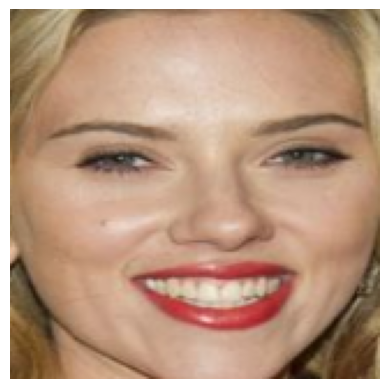

In [11]:
img = cv2.imread("Celebrity Faces Dataset/Scarlett Johansson/010_4eb6eabe.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
results = detector.detect_faces(img)
face,x,y,p = get_face(img,results[0]['box'])
plt.axis('off')
plt.imshow(face)

# Getting faces and labels from data

In [12]:
X,y = get_faces()

# Encoding faces using FaceNet and labels using LabelEncoder

In [13]:
X_embedding = prepare_model_data(X)

In [14]:
y

array(['Angelina Jolie', 'Angelina Jolie', 'Angelina Jolie', ...,
       'Leonardo DiCaprio', 'Leonardo DiCaprio', 'Leonardo DiCaprio'],
      dtype='<U18')

In [15]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [16]:
y

array([0, 0, 0, ..., 7, 7, 7])

In [17]:
class_names = encoder.classes_

In [18]:
y.shape

(1800,)

# Splitting Data into train and test and training the model

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_embedding,y,random_state=7,shuffle=True,stratify=y)

In [20]:
y_train

array([ 9,  6, 15, ...,  2,  9,  2])

In [21]:
X_train.shape

(1350, 512)

In [22]:
model = SVC(kernel = 'linear',probability = True)

In [23]:
model.fit(X_train,y_train)

SVC(kernel='linear', probability=True)

# Evaluating the model

In [24]:
model.score(X_train,y_train)

0.9977777777777778

In [25]:
model.score(X_test,y_test)

0.9866666666666667

In [26]:
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       1.00      0.96      0.98        25
           2       0.93      1.00      0.96        25
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00        25
           6       1.00      0.96      0.98        25
           7       1.00      1.00      1.00        25
           8       1.00      1.00      1.00        25
           9       1.00      0.96      0.98        25
          10       0.96      1.00      0.98        25
          11       1.00      0.96      0.98        25
          12       0.96      0.96      0.96        25
          13       0.98      1.00      0.99        50
          14       0.96      1.00      0.98        25
          15       1.00      1.00      1.00        25
          16       1.00      1.00      1.00        25

    accuracy              

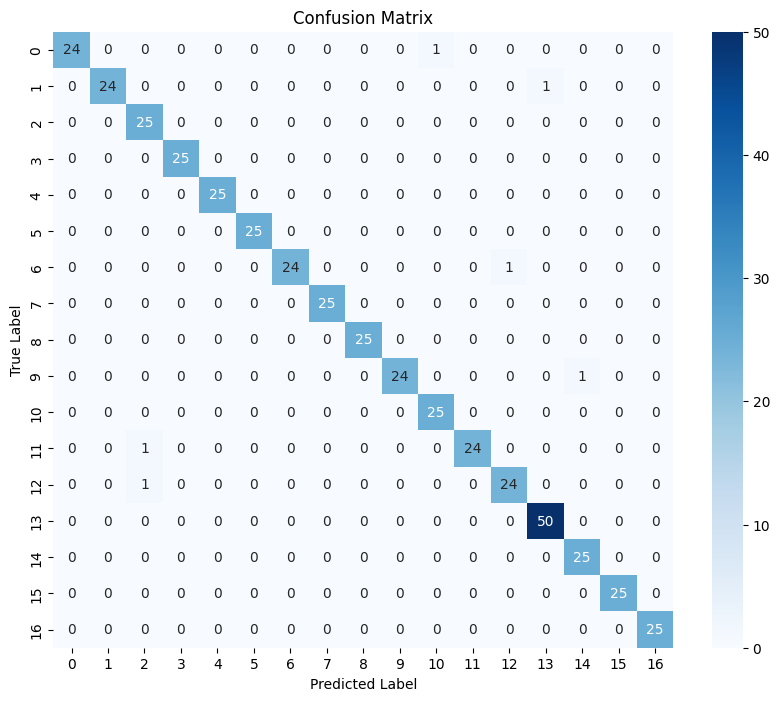

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [28]:
with open("svm_face_recognition_model.pkl",'wb') as file:
    pickle.dump(model,file)

# Testing a pipline for detecting all faces in an image and recognizing them

In [29]:
detector = MTCNN()
embedder = FaceNet()

## Image before detecting

This is an image i got from google

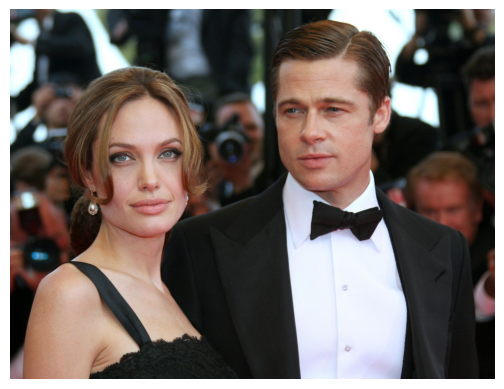

In [30]:
img_path = r"test.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

In [31]:
img.shape

(2289, 3000, 3)

## Image after detecting

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


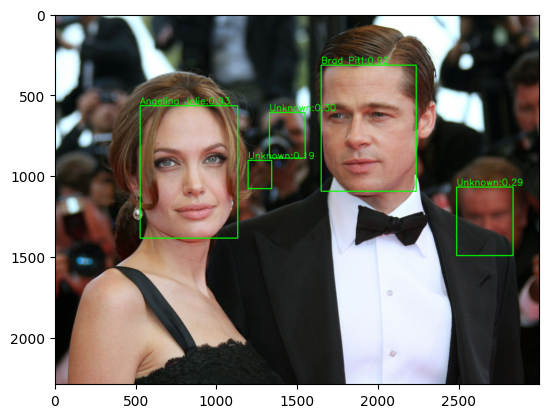

In [32]:
pred_img = detect_recognize_faces(img_path)
plt.imshow(pred_img)